# Text Classification with Neural Networks

The goal of this project is to develop a **classification model to predict the positive/negative labels** of movie reviews.

We'll be using the **large movie review dataset**, https://ai.stanford.edu/~amaas/data/sentiment/, compiled by Maas et al. (https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). This dataset can be loaded directly via the Keras imdb.load_data() method.

#### 1. Perform initial imports

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint

import os

import numpy as np
import pandas as pd

Using TensorFlow backend.


#### 2. Load data

In [2]:
# values used in Maas et al.:
#"We build a fixed dictionary of the 5,000 most frequent tokens, 
#but ignore the 50 most frequent terms from the original full vocabulary."

n_unique_words = 5000 #number of most frequent words to consider
n_words_to_skip = 0 #50 #number of most frequent words to ignore

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words, 
                                                      skip_top=n_words_to_skip)

#### 3. Check data

In [3]:
#check 3 first reviews of the training data

x_train[0:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369,

Each token is represented by an integer, following this convention:
* **0** is the **padding token**
* **1** is the **starting token**, indicating the beginning of a review
* **2** is the **unknown token**, used to identify the out-of-vocabulary (OOV) words 
* **3** is the **most frequent word** in the corpus
* **4** is the **second most frequent word** in the corpus, and so on

In [4]:
# integer 3 is not used
n_3=0
n_4=0

for index in range(len(x_train)):
    n_3 += x_train[index].count(3)
    n_4 += x_train[index].count(4)

print(n_3, n_4)

0 336148


In [5]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

218
189
141


As expected, the reviews have different lengths.

In [6]:
# check labels of the 3 first reviews of the training data

y_train[0:3]

array([1, 0, 0], dtype=int64)

The first review is positive and the second and third reviews are negative.

In [7]:
# check length of the training and test set

len(x_train), len(x_test)

(25000, 25000)

We have 25000 reviews in the training set and 25000 reviews in the test set.

#### 4. Check reviews as a sequence of words (and not integers)

Instead of having a sequence of integers for each review, we can also check their original content using Keras imdb.get_word_index() method. 

In [8]:
word_index = imdb.get_word_index()

for key, value in word_index.items():
    if (value == 0) or (value == 1) or (value == 2):
        print(key, value)

the 1
and 2


In [9]:
print(min(word_index, key=word_index.get), word_index[min(word_index, key=word_index.get)])

the 1


As we can see, the first integers are not reserved for the special cases we've mentioned before (and the values start in 1).

In [10]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
#word_index["<UNUSED>"] = 3

In [11]:
# 3 is not used!!!
for key, value in word_index.items():
    if value == 3:
        print(key, value)

In [12]:
# the most common word is "the"
word_index['the']

4

In [13]:
# inverting the word_index dictionary

index_word = {v:k for k,v in word_index.items()}

index_word[4]

'the'

In [14]:
# first review of the training set as a sequence of words

' '.join(index_word[id] for id in x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly UNK was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you 

This is the first review of the training set. Since we've excluded some words with the parameters `num_words` and `skip_top` when loading the reviews, those words are identified by the string 'UNK'.

Let's view this first original review.

#### 5. Check original reviews as a sequence of words

In [15]:
(original_x_train,_), (original_x_test,_) = imdb.load_data()

In [16]:
' '.join(index_word[id] for id in original_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### 6. Preprocess data

In [17]:
# make each review the same length using 0 as the padding value

max_review_length = 100 #maximum review length of 100 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

In [18]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

100
100
100


All the reviews have now the **same length of 100 words**.

In [19]:
# first review of the training set as a sequence of words after preprocessing

' '.join(index_word[id] for id in x_train[0])

"cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was UNK with us all"

As we can see, this review was truncated in order to keep the last 100 words.

#### 7. Design a dense neural network

In [20]:
# output directory name:
output_dir = 'text_classification_NN/dense'

# training:
epochs = 4
batch_size = 128

n_dim = 64 #number of dimensions of our word-vector space

# neural network architecture: 
n_dense = 64 #number of neurons in dense layer
dropout = 0.5

model = Sequential(name='model_dense')
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [21]:
model.summary()

Model: "model_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


We have designed our model. It's now time to compile it!

#### 8. Compile model and create callback to save model parameters

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Our model is now compiled. We've used `binary_crossentropy` as our loss function since we have a binary classifier.

In [23]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [24]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 9. Train model

In [25]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 4s 158us/step - loss: 0.5040 - accuracy: 0.7370 - val_loss: 0.3621 - val_accuracy: 0.8352
Epoch 2/4
25000/25000 [==============================] - 4s 155us/step - loss: 0.2357 - accuracy: 0.9084 - val_loss: 0.3594 - val_accuracy: 0.8446
Epoch 3/4
25000/25000 [==============================] - 4s 161us/step - loss: 0.0789 - accuracy: 0.9789 - val_loss: 0.4520 - val_accuracy: 0.8340
Epoch 4/4
25000/25000 [==============================] - 4s 160us/step - loss: 0.0172 - accuracy: 0.9984 - val_loss: 0.5466 - val_accuracy: 0.8337


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 2**.

#### 10. Make predictions with the test set

In [26]:
# load parameters of epoch 2

model.load_weights(output_dir+"/weights.02.hdf5")

In [27]:
# in Keras, for this specific case, we can use both predict() and predict_proba() to get the predicted probabilities

predictions = model.predict(x_test)
predictions_proba = model.predict_proba(x_test)

In [28]:
predictions[0:3]

array([[0.03857177],
       [0.97907937],
       [0.7320579 ]], dtype=float32)

In [29]:
predictions_proba[0:3]

array([[0.03857177],
       [0.97907937],
       [0.7320579 ]], dtype=float32)

In [30]:
# if we want to get the classes directly, we can use predict_classes()

predictions_class = model.predict_classes(x_test)

In [31]:
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 11. Evaluate model

We can start by comparing the first 10 predictions with the real labels.

In [32]:
predictions_class[0:10].T

array([[0, 1, 1, 1, 1, 1, 1, 0, 1, 1]])

In [33]:
y_test[0:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

For the first 10 reviews, only one seems to be misclassified. Let's investigate this further.

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [35]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10658  1842]
 [ 2043 10457]]


In [36]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [37]:
# accuracy score

print(accuracy_score(y_test, predictions_class))

0.8446


As we've seen before when we trained it, our dense model correctly classifies **84,5%** of our reviews as positive or negative.

Another useful metric to evaluate the performance of our binary classifier is the **area under the curve of the receiver operating characteristic**, or the AUC of the ROC (also known as **ROC AUC**).

The ROC AUC combines two different metrics - **true positive rate (TPR)** and **false positive rate (FPR)**.<br><br>

* $ TPR = \frac{TP}{TP+FN} $
<br><br>
* $ FPR = \frac{FP}{FP+TN} $

Let's plot the ROC curve and calculate the ROC AUC value of our model.

In [38]:
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

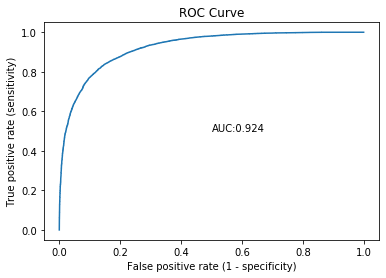

In [52]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc))
plt.title('ROC Curve');

Our dense model has a ROC AUC value of 0.924.

We can also have a look into some of the reviews that were incorrectly classified to have a sense of what's going on. In order to do that, let's create a dataframe with the predicted values for each review and the corresponding original label.

In [40]:
pred_values = []

for prediction in predictions:
    pred_values.append(prediction[0])

In [41]:
df = pd.DataFrame(list(zip(pred_values, y_test)), columns=['y_pred', 'y'])

In [42]:
df.head()

y_pred  y
0  0.038572  0
1  0.979079  1
2  0.732058  1
3  0.505129  0
4  0.990228  1

Let's focus on the more extreme cases, i. e., misclassified reviews with predicted probabilities of being positive higher than 0.9 or lower than 0.1.

In [43]:
# negative reviews incorrectly classified with predicted probability of being positive > 0.9

df[(df.y == 0) & (df.y_pred > 0.9)].head(10)

y_pred  y
66   0.946340  0
152  0.955964  0
256  0.903766  0
299  0.928912  0
386  0.976138  0
438  0.907497  0
547  0.972812  0
593  0.960397  0
614  0.918750  0
693  0.975051  0

In [44]:
# check original review with index 66

neg_review = ' '.join(index_word[id] for id in original_x_test[66])

' '.join(neg_review.split()[-100:]) # our model only considers the last 100 words

"comparisons here br br nothing personal here guys i do hope you can make another movie someday and we all have to start out somewhere so forgive me if i've been too harsh i am glad that you are proud of what you created which in the end is what life is all about it's not a movie i would recommend though br br oh i did like the way the time frames often collided thought that was an interesting way to film br br but the whole its the quiet ones you have to watch we already know that"

In [45]:
# positive reviews incorrectly classified with predicted probability of being positive < 0.1

df[(df.y == 1) & (df.y_pred < 0.1)].head(10)

y_pred  y
72   0.082092  1
100  0.017882  1
101  0.062933  1
159  0.039866  1
167  0.031235  1
248  0.043888  1
300  0.020516  1
325  0.031130  1
333  0.060481  1
345  0.054684  1

In [46]:
# check original review with index 72

pos_review = ' '.join(index_word[id] for id in original_x_test[72])

' '.join(pos_review.split()[-100:]) # our model only considers the last 100 words

"alice is the kind of movie they made in the 30's and 40's never attempts to be an event just wants to entertain and it does i was surprised by kiefer sutherland in a role that could be a cliche he made it real the plot does make allusions to alice in wonderland a guy dressed in white does go through a hole and kiefer does fall down one like alice the plot does twist and turn but with a freshness you don't see in small movies i loved the direction sutherland just a very fast paced and interesting movie"

It's not easy to determine why our model was not able to correctly classify these examples, but it can be useful to have the possibility of doing this kind of ad hoc analysis.